In [3]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import sklearn
import pickle

In [4]:
from sklearn.svm import SVR
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.cluster import SpectralClustering
from scipy.interpolate  import lagrange

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error,r2_score

## Read land scan urban extent data, produced by R

In [7]:
ls=pd.read_csv("lsfinal1999.csv").iloc[:,2:]
ls=ls.drop(["corX","corY"],axis=1)
for i in range(29):
    ls.iloc[8:37,1].values[i]=ls.iloc[8:37,1].values[i][1:]
lsv=ls.iloc[:,4:]
ls=ls.drop(['radius','1999_ls'],axis=1)

## Read World bank data

In [8]:
wb_gdp=pd.read_csv("wb_gdp.csv",skiprows=3).iloc[:]
wb_pop=pd.read_csv("wb_pop.csv",skiprows=3).iloc[:]

## Merge World bank data with LS data.

In [9]:
wb_gdp2=wb_gdp.iloc[:,[0,1]+list(range(44,62))]
wb_gdp2=wb_gdp2.rename(columns={"Country Name":"country_x"})
wb_gdp2=wb_gdp2.merge(ls.iloc[:,[0,1]])
wb_gdp2=wb_gdp2.iloc[:,[-1,0]+list(range(2,2+18))]

wb_pop2=wb_pop.iloc[:,[0,1]+list(range(44,62))]
wb_pop2=wb_pop2.rename(columns={"Country Name":"country_x"})
wb_pop2=wb_pop2.merge(ls.iloc[:,[0,1]])
wb_pop2=wb_pop2.iloc[:,[-1,0]+list(range(2,2+18))]

gdp=ls.iloc[:,[0]].merge(wb_gdp2)
pop=ls.iloc[:,[0]].merge(wb_pop2)

## Read GUSPS urban area at 50 threshold.

In [10]:
sl_50=pd.read_csv("sleuthfinal_50.csv").iloc[:,7:].values

## Smoothing historical data.
## Land Scan , Worldbank

In [11]:
def hann(data0):
    data=data0.values[:,2:]
    data1=data0.copy()
    test0=np.zeros(16)
    for i in range(16):
        data1.iloc[:,3+i]=np.sum(data[:,i:i+3]*np.array([0.25,0.5,0.25]),axis=1)#.reshape(-1,1)
    return data1.iloc[:,3:3+16]

ls_ha=hann(ls)
gdp_ha=hann(gdp)
pop_ha=hann(pop)

smooth_history={0:ls_ha,1:gdp_ha/10**9,2:pop_ha/10**6}

## Read SSP

In [12]:
datap=pd.read_csv("datap_15_60.csv").iloc[:,8:]
datar=pd.read_csv("datar.csv").iloc[:,[8,9,12,13]]
datar.head()

datar2=datar.copy()
datar2["indd"]=(np.arange(114)*5)
datar2=datar2.set_index("indd")
datar3=datar.copy()
for i in range(1,5):
    datar3["indd"]=(np.arange(114)*5+i)
    datar3=datar3.set_index("indd")
    datar2=pd.concat([datar2,datar3])

datar2=datar2.sort_values(by ='indd').reset_index().iloc[:,1:]

datar2=pd.concat([datar2,datap],axis=1)
ssp_gdp=datar2.iloc[:,2:13+2]
ssp_pop=pd.concat([datar2.iloc[:,:2],datar2.iloc[:,13+2:]],axis=1)

In [13]:
ssp_gdps={}
ssp_pops={}
for i in range(5):
    ssp_gdps.update({i+1:ssp_gdp.iloc[np.arange(0,570,5)+i,:].reset_index().iloc[:,1:]})
    ssp_pops.update({i+1:ssp_pop.iloc[np.arange(0,570,5)+i,:].reset_index().iloc[:,1:]})

In [15]:
ind_c=ls.iloc[:,[0]]
ind_c2=pd.read_csv("datar.csv").iloc[:,[1]]
ind_c2["iii"]=np.arange(114)
iii=ind_c.merge(ind_c2).values[:,1].astype("int")

In [16]:
for i in range(1,6):
    ssp_gdps[i]=ssp_gdps[i].iloc[iii,:].reset_index().iloc[:,1:]
    ssp_pops[i]=ssp_pops[i].iloc[iii,:].reset_index().iloc[:,1:]

In [17]:
x0050=np.arange(2000,2051)
x0215=np.arange(2002,2016)
x0017=np.arange(2000,2018)
x1650=np.arange(2016,2051)
x1550=np.arange(2015,2051)
x0116=np.arange(2001,2017)

# ssp_gdps_lag : interpolate SSP from 2000 to 2050.

In [18]:
x=np.arange(0,51,5)
x2=np.arange(0,51)
x=np.arange(0,61,5)
x2=np.arange(15,51)
ssp_gdps_lag=ssp_gdps.copy()
ssp_pops_lag=ssp_pops.copy()

for sspn in range(5):
    dg=np.empty([114,36])
    dp=np.empty([114,36])
    for i in range(114):
        yg=ssp_gdps[sspn+1].values[i]
        yp=ssp_pops[sspn+1].values[i]
        dg[i]=lagrange(x,yg)(x2)
        dp[i]=lagrange(x,yp)(x2)
    ssp_gdps_lag[sspn+1]=pd.DataFrame(dg)
    ssp_pops_lag[sspn+1]=pd.DataFrame(dp)

## adjusting SSP to Worlbank,2015

In [19]:
for sspn in range(1,6):
    x1=smooth_history[2].values[:,-2]
    x2=ssp_pops_lag[sspn].values[:,0]
    x3=ssp_pops_lag[sspn].values[:,:]
    ssp_pops_lag[sspn].values[:,:]=x3*(x1/x2).reshape(-1,1)

    x1=smooth_history[1].values[:,-2]
    x2=ssp_gdps_lag[sspn].values[:,0]
    x3=ssp_gdps_lag[sspn].values[:,:]
    ssp_gdps_lag[sspn].values[:,:]=x3*(x1/x2).reshape(-1,1)

## Regression for single city

In [133]:
# [0,6,38,100]
ct=[0]
ts0=12
r2=np.empty(ts0)
coef1=np.empty(ts0)
coef2=np.empty(ts0)
inter=np.empty(ts0)
ts_dic=np.arange(ts0)+1
bestr2=[-100,0]
bestmodel=None
y=smooth_history[0].values[ct]
x1=smooth_history[1].values[ct]
x2=smooth_history[2].values[ct]
datas={0:y,1:x1,2:x2}

for ts in range(1,1+ts0):
    df={}
    for para in range(3):
        data1=datas[para][:,:-ts]
        data2=datas[para][:,ts:]#.reshape(-1)
        dif=(data2-data1)/data1
        df.update({para:dif.reshape(-1)})
    dataset=pd.DataFrame(df)
    model = LinearRegression(fit_intercept=False)
    model = Lasso(alpha = 0)
    model = Lasso(alpha=0,fit_intercept=0,positive=1)
#     model = Lasso(alpha=0,fit_intercept=1,positive=0)
#     model = Lasso(alpha = 0, positive=True,fit_intercept=False)
#     model = RandomForestRegressor()
    dataset.iloc[:,:][dataset.iloc[:,:]<0]=0
    train_X=dataset.iloc[:,[1,2]]
    train_Y=dataset.iloc[:,[0]].values.reshape(-1,1)
    model.fit(train_X,train_Y)
    pred_Y=model.predict(train_X)
    r2score=r2_score(train_Y,pred_Y)
    
    n=train_Y.size
    p=2
    adj_r2score=1-(1-r2score)*(n-1)/(n-1-p)
    r2[ts-1]=adj_r2score
    if bestr2[0]<adj_r2score:
        bestr2=[adj_r2score,ts]
        bestmodel=model
        bestdata=dataset
        
    models=pd.DataFrame({"time_step":ts_dic,"adj_r2":r2})
    coef1[ts-1]=model.coef_.reshape(-1)[0]
    coef2[ts-1]=model.coef_.reshape(-1)[1]
    inter[ts-1]=model.intercept_
    models=pd.DataFrame({"time_step":ts_dic,"adj_r2":r2,"coef_gdp":coef1,"coef_pop":coef2,"intercept":inter})
print(bestr2)
print(n,p)
models

[0.3217302119440443, 9]
4 2


,time_step,adj_r2,coef_gdp,coef_pop,intercept
0,1,-0.072098,0.000000,8.828951,0.0
1,2,-0.053380,0.000000,9.455631,0.0
2,3,-0.048425,0.000000,9.542210,0.0
3,4,-0.051426,0.000000,9.184788,0.0
4,5,-0.052722,0.000000,8.736054,0.0
5,6,-0.053541,0.000000,8.167495,0.0
6,7,-0.026027,0.000000,7.720535,0.0
7,8,0.055919,0.036693,5.234014,0.0
8,9,0.321730,0.110327,0.000000,0.0
9,10,0.220515,0.112394,0.000000,0.0


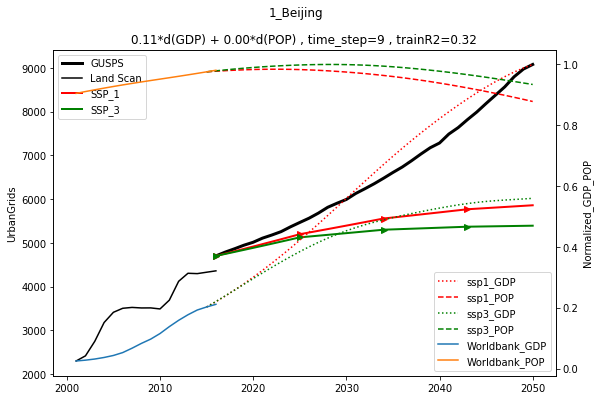

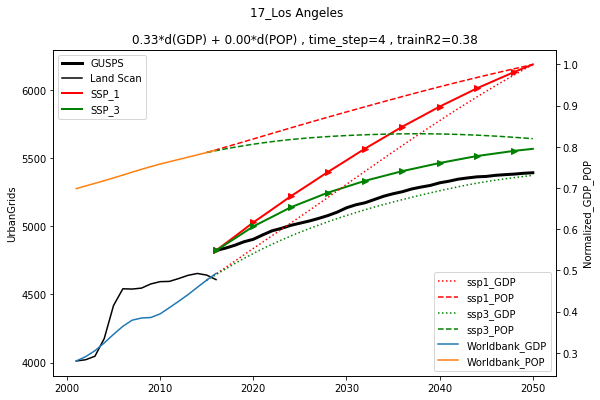

In [23]:
# for cti in [0,3,6,8]:
for cti in [0,16]:
# for cti in range(114):
    ct=[cti]
    ts0=12
    r2=np.empty(ts0)
    coef1=np.empty(ts0)
    coef2=np.empty(ts0)
    inter=np.empty(ts0)
    ts_dic=np.arange(ts0)+1
    bestr2=[-100,0]
    bestmodel=None
    y=smooth_history[0].values[ct]
    x1=smooth_history[1].values[ct]
    x2=smooth_history[2].values[ct]
    datas={0:y,1:x1,2:x2}
    for ts in range(1,1+ts0):
        df={}
        for para in range(3):
            data1=datas[para][:,:-ts]
            data2=datas[para][:,ts:]#.reshape(-1)
            dif=(data2-data1)/data1
            df.update({para:dif.reshape(-1)})
        dataset=pd.DataFrame(df)
        model = Lasso(alpha=0,fit_intercept=0,positive=1)
#         model = Lasso(alpha=0,fit_intercept=1,positive=0)
#         model = Lasso(alpha=0,fit_intercept=0)
        dataset.iloc[:,:][dataset.iloc[:,:]<0]=0
        train_X=dataset.iloc[:,[1,2]]
        train_Y=dataset.iloc[:,[0]].values.reshape(-1,1)
        model.fit(train_X,train_Y)
        pred_Y=model.predict(train_X)
        r2score=r2_score(train_Y,pred_Y)
       
        n=train_Y.size
        p=2
        adj_r2score=1-(1-r2score)*(n-1)/(n-1-p)
        r2[ts-1]=adj_r2score
        if bestr2[0]<adj_r2score:
            bestr2=[adj_r2score,ts]
            bestmodel=model
            bestdata=dataset
        coef1[ts-1]=model.coef_[0]
        coef2[ts-1]=model.coef_[1]
        inter[ts-1]=model.intercept_
        models=pd.DataFrame({"time_step":ts_dic,"adj_r2":r2,"coef_gdp":coef1,"coef_pop":coef2,"intercept":inter})
#     print(bestr2)

    fig = plt.figure(figsize=(9,6))
    ax1 = fig.add_subplot(111)
    plt.ylabel("UrbanGrids")
    ax2 = ax1.twinx()
    ct=cti
    ts=bestr2[1]
    num=34//bestr2[1]
    ax1.plot(x1650,sl_50[ct,:],"k",label="GUSPS",linewidth=3)
    ax1.plot(x0116,smooth_history[0].iloc[ct,:],"k",label="Land Scan")
    maxs_p=[]
    maxs_g=[]
    for sspn in [1,3]:
        maxs_g.append(np.max(ssp_gdps_lag[sspn].iloc[ct,:]))
        maxs_p.append(np.max(ssp_pops_lag[sspn].iloc[ct,:]))
    max_p,max_g=max(maxs_p),max(maxs_g)
    for sspn in [1,3]:
        if 0:
            ua0=sl_50[ct].copy()
            ua=sl_50[ct,ts:].copy()
            xplot=np.arange(2016+ts,2051)
            for i in range(35-ts):
                x1=ssp_gdps_lag[sspn].iloc[ct,ts+i]/ssp_gdps_lag[sspn].iloc[ct,i]-1
                x2=ssp_pops_lag[sspn].iloc[ct,ts+i]/ssp_pops_lag[sspn].iloc[ct,i]-1
                x_test=np.hstack([x1,x2])
                x_test[x_test<0]=0
                rate=bestmodel.predict(x_test.reshape(-1,2))
                ua[i]=ua0[i]*(rate+1)
        if 1:
            ua=np.zeros(35)
            ua[0]=sl_50[ct,0]
            xplot=np.arange(2016,2051)
            xpoint=np.arange(num+1)
            for i in range(1,num+1):
                x1=ssp_gdps_lag[sspn].iloc[ct,i*ts]/ssp_gdps_lag[sspn].iloc[ct,i*ts-ts]-1
                x2=ssp_pops_lag[sspn].iloc[ct,i*ts]/ssp_pops_lag[sspn].iloc[ct,i*ts-ts]-1
                x_test=np.hstack([x1,x2])
                x_test[x_test<0]=0
                rate=bestmodel.predict(x_test.reshape(-1,2))
                ua[i*ts]=ua[(i-1)*ts]*(rate+1)
                xpoint[i]=i*ts
            if (34%ts)!=0:
                x1=ssp_gdps_lag[sspn].iloc[ct,-1]/ssp_gdps_lag[sspn].iloc[ct,-1-ts]-1
                x2=ssp_pops_lag[sspn].iloc[ct,-1]/ssp_pops_lag[sspn].iloc[ct,-1-ts]-1
                x_test=np.hstack([x1,x2])
                x_test[x_test<0]=0
                rate=bestmodel.predict(x_test.reshape(-1,2))
                rate=(1+rate)**((34%ts)/ts)-1
                ua[-1]=ua[num*ts]*(rate+1)
            for i in range(num):
                for j in range(1,ts):
                    ua[i*ts+j]=(ua[ts+i*ts]/ua[i*ts])**(j/ts)*ua[i*ts]
            if 34%ts > 1:
                for j in range(1,34%ts):
                    ua[num*ts+j]=(ua[-1]/ua[num*ts])**(j/(34%ts))*ua[num*ts]
                    
        ax1.plot(xpoint+2016,ua[xpoint],">"+"gr"[sspn//2-1])
        ax1.plot(xplot,ua,"-"+"gr"[sspn//2-1],label="SSP_%d"%sspn,linewidth=2)
        gdp_norm=ssp_gdps_lag[sspn].iloc[ct,:]/max_g
        ax2.plot(x1550, gdp_norm[:],":"+"gr"[sspn//2-1],label="ssp"+str(sspn)+"_GDP")
        pop_norm=ssp_pops_lag[sspn].iloc[ct,:]/max_p
        ax2.plot(x1550, pop_norm[:],"--"+"gr"[sspn//2-1],label="ssp"+str(sspn)+"_POP")
        
    ax2.plot(x0116, smooth_history[1].iloc[ct,:]/max(maxs_g),label="Worldbank_GDP")
    ax2.plot(x0116, smooth_history[2].iloc[ct,:]/max(maxs_p),label="Worldbank_POP")
    ax1.legend()
    ax2.legend(loc=4)
    title0=str(ct+1)+"_"+ls.iloc[ct,0]
    title2="%.2f*d(GDP) + %.2f*d(POP) , time_step=%d , trainR2=%.2f"%(bestmodel.coef_[0],bestmodel.coef_[1], bestr2[1],bestr2[0])
#     title2="%.2f*d(GDP) + %.2f*d(POP) + %.3f , time_step=%d , trainR2=%.2f"%(bestmodel.coef_[0],bestmodel.coef_[1],bestmodel.intercept_, bestr2[1],bestr2[0])
    plt.title(title2)
    plt.suptitle(title0)
    plt.xlabel("year")

    plt.ylabel("Normalized_GDP_POP")
#     plt.savefig("png_final_threshold_50/%d.png"%ct)
#     plt.close()
    
#     break